In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "segmented_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
labels = []
image_paths = []
for key, item in list(image_dict.items()):
    for image_path in item:
        labels.append(list(image_dict.keys()).index(key))
        image_paths.append(image_path)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=205)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=205)
print(len(X_train), len(X_val), len(X_test))
print(*image_dict.keys(), sep=', ')

2492 624 779
Astrocitoma, Meningioma, Carcinoma, Neurocitoma, Papiloma, Glioblastoma, Schwannoma, _NORMAL, Ependimoma, Oligodendroglioma


In [28]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_path, image_paths, labels, seq_len, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_paths = image_paths
        self.image_class_list = labels
        self.seq_len = seq_len
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        # Return the number of sequences we can create from the dataset
        return (len(self.image_class_list) // self.seq_len)

    def __getitem__(self, idx):
        # Get the index range for the sequence
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len
        
        # Create a sequence of images and get the corresponding label
        images = []
        for i in range(start_idx, end_idx):
            img_path = os.path.join(self.data_path, self.image_paths[i])
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if self.transform:
                image = self.transform(image)
            images.append(image)
        
        # Get the label for the sequence
        label = self.image_class_list[start_idx]  
        if self.transform_label:
            label = self.transform_label(label)

        # Stack images into a single tensor
        return torch.stack(images), label  # Return the sequence of images and label

In [40]:
learning_rate = 1e-3
batch_size = 32
freeze_epochs = 20
unfreeze_epochs = 800
num_classes = len(image_dict.keys())

In [5]:
training_transform = transforms.Compose([transforms.ToTensor(),
                                   #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                   transforms.RandomRotation(45),
                                   transforms.RandomHorizontalFlip(p=0.5)])

In [29]:
seq_len = 5  # Number of images per sequence

train_dataset = BrainTumorDataset(data_path, X_train, y_train, seq_len=seq_len, transform=training_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(data_path, X_test, y_test, seq_len=seq_len, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = BrainTumorDataset(data_path, X_val, y_val, seq_len=seq_len, transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([32, 5, 1, 256, 256])
Labels batch shape: torch.Size([32])


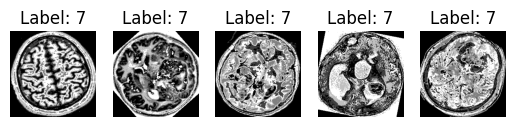

In [31]:
# Display the first sequence of images and its label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Number of images in the sequence
seq_len = train_features.size(1)

# Display each image in the sequence
for i in range(seq_len):
    image = train_features[0][i].squeeze()  # Get the i-th image from the first sequence
    label = train_labels[0]  # Get the label for the first sequence
    plt.subplot(1, seq_len, i + 1)  # Create a subplot for each image
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(f"Label: {label.item() if isinstance(label, torch.Tensor) else label}")

plt.show()

In [36]:
class CNNRNNModel(nn.Module):
    def __init__(self, n_classes, seq_len):
        super(CNNRNNModel, self).__init__()

        # Load pretrained AlexNet and modify the first layer for single-channel input
        self.cnn = torchvision.models.alexnet(pretrained=True)
        self.cnn.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Remove the classifier part of AlexNet, we only need the features
        self.cnn.classifier = nn.Identity()  # Replace classifier with identity

        # LSTM layer to process features from the CNN
        self.rnn = nn.LSTM(input_size=9216, hidden_size=128, num_layers=1, batch_first=True)  # 9216 = 256 * 6 * 6 (output size from AlexNet)

        # Fully connected layer for classification
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, channels, height, width)
        batch_size, seq_len, channels, height, width = x.size()

        # Pass through CNN (AlexNet)
        x = x.view(-1, channels, height, width)  # Reshape for CNN
        x = self.cnn(x)  # CNN output shape: (batch_size * seq_len, 9216)

        # Reshape to (batch_size, seq_len, feature_size)
        x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, 9216)

        # RNN forward pass
        rnn_out, (hn, cn) = self.rnn(x)  # Output shape: (batch_size, seq_len, 128)

        # Take the output from the last time step
        out = self.fc(hn[-1])  # (batch_size, n_classes)
        return out

In [37]:
# Example usage
n_classes = len(image_dict.keys())
seq_len = 5    # Number of images in a sequence
model = CNNRNNModel(n_classes, seq_len)

# Move the model to the appropriate device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNRNNModel(
  (cnn): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Identity()
  )
  (rnn): LSTM(9216, 128, batch_first=True)
  (f

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Training loss: 0.836330, validation loss: 0.212723
Time elapsed: 866.82594871521
------------ Epoch: 1 ------------
Training loss: 0.831142, validation loss: 0.213139
Time elapsed: 777.1151392459869
------------ Epoch: 2 ------------
Training loss: 0.832865, validation loss: 0.213534
Time elapsed: 801.6282579898834
------------ Epoch: 3 ------------
Training loss: 0.829919, validation loss: 0.213671
Time elapsed: 948.1149399280548
------------ Epoch: 4 ------------
Training loss: 0.831477, validation loss: 0.213695
Time elapsed: 959.0002071857452
------------ Epoch: 5 ------------
Training loss: 0.831232, validation loss: 0.213593
Time elapsed: 863.3020858764648
------------ Epoch: 6 ------------
Training loss: 0.830823, validation loss: 0.213875
Time elapsed: 743.7986950874329
------------ Epoch: 7 ------------
Training loss: 0.831858, validation loss: 0.214031
Time elapsed: 767.4564590454102
------------ Epoch: 8 ------------
Training loss: 0.828543

Text(0.5, 0, 'Epoch')

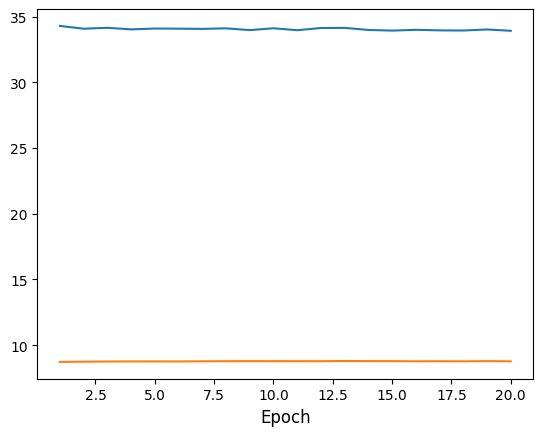

In [41]:
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)
for epoch in range(freeze_epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
    
    for batch, (X, y) in enumerate(val_dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        valid_loss += loss.item()
        
    scheduler.step()    
    print(f"Training loss: {training_loss/41:>7f}, validation loss: {valid_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, freeze_epochs+1), all_loss)
plt.plot(range(1, freeze_epochs+1), all_valid_loss)
plt.xlabel('Epoch', fontsize=12)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        28
           1       0.20      1.00      0.33        31
           2       1.00      0.00      0.00        13
           3       1.00      0.00      0.00        14
           4       1.00      0.00      0.00        10
           5       1.00      0.00      0.00        11
           6       1.00      0.00      0.00        16
           7       1.00      0.00      0.00        21
           8       1.00      0.00      0.00         7
           9       1.00      0.00      0.00         4

    accuracy                           0.20       155
   macro avg       0.92      0.10      0.03       155
weighted avg       0.84      0.20      0.07       155



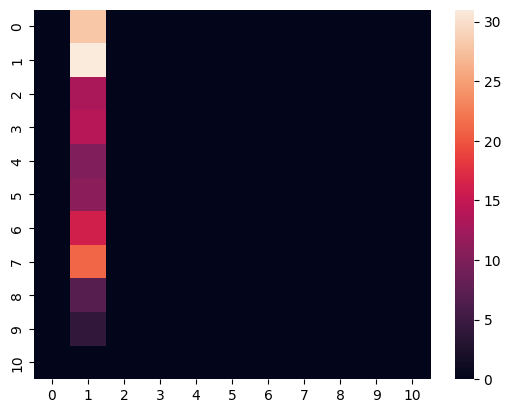

In [42]:
model.to('cpu')
predictions, labels = [], []
for batch, (X, y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    labels += y.tolist()

sns.heatmap(confusion_matrix(labels, predictions, labels=range(0, 11)))
print(classification_report(labels, predictions, zero_division=1))